# DMS-MaPseq

In [44]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../../src')
from util import *
from config import *
import ipynbname

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### # Mutations per read
- histogram
- x-axis = # mutations
- y-axis = # reads


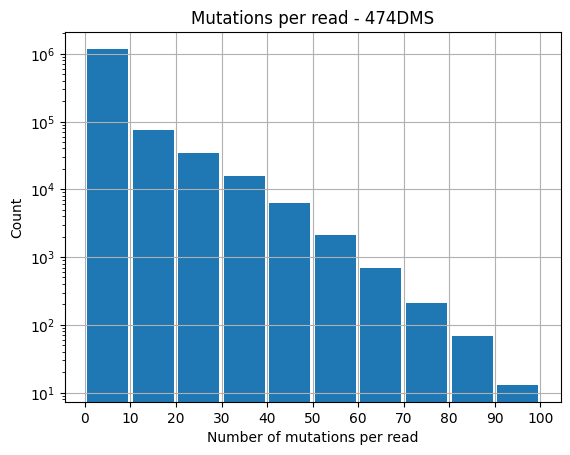

In [11]:
for sample in study.df['sample'].unique():
    mutations_per_read(study, sample)
    savefig2(ipynbname.path(), '[A] Mutations per read')
    if not config.generate_plots:
        break

### Mutation identity at each position
- stacked bar graph (ACUG coloring)
- x-axis = position (number/base/both??)
- y-axis = # reads


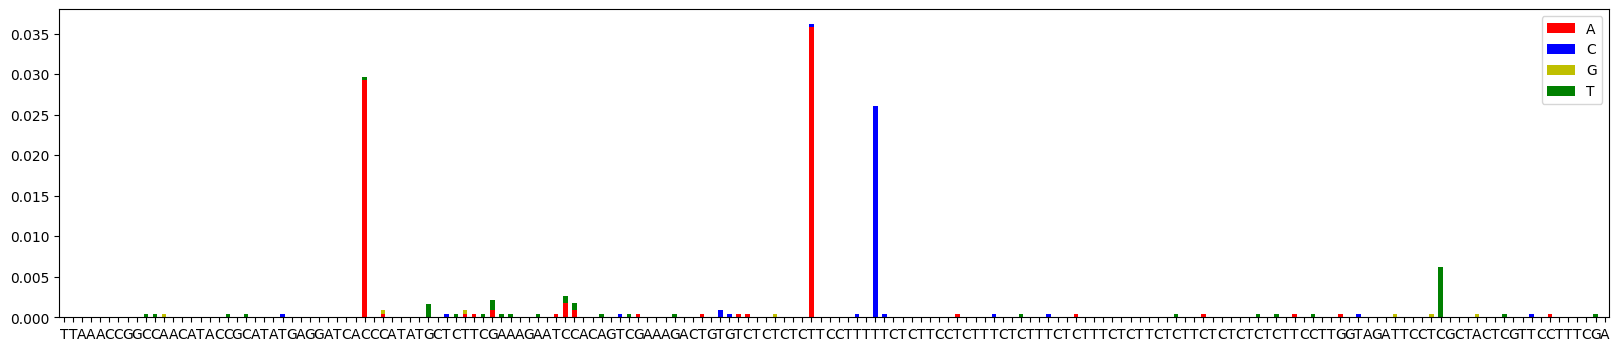

In [42]:
for sample in study.df['sample'].unique():
    for construct in study.get_df(sample=sample)['construct'].unique():
        mutation_identity_at_each_position(study, sample, construct)
        savefig2(ipynbname.path(), '[B] Mutation identity at each position')
        if not config.generate_plots:
            break  

### Mutation fraction at each position 
- bar graph (ACUG coloring)
- x-axis = position (number/base/both??)
- y-axis = # reads


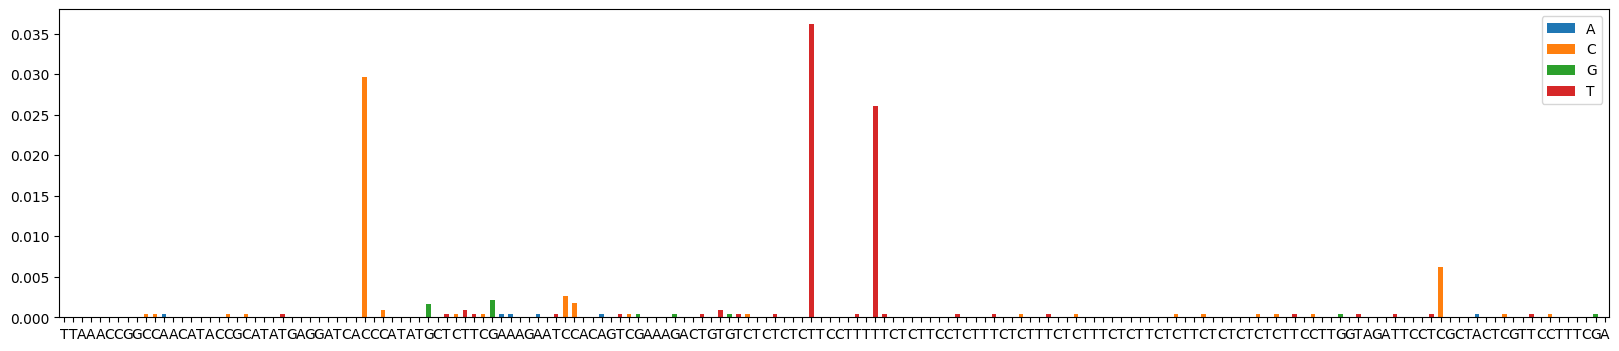

In [57]:
for sample in study.df['sample'].unique():
    for construct in study.get_df(sample=sample)['construct'].unique():
        mutation_fraction_at_each_position(study, sample, construct)
        savefig2(ipynbname.path(), '[C] Mutation fraction at each position')
        if not config.generate_plots:
            break  

### Read coverage per position
- bar graph
- x-axis = position (number/base/both??)
- y-axis = coverage fraction

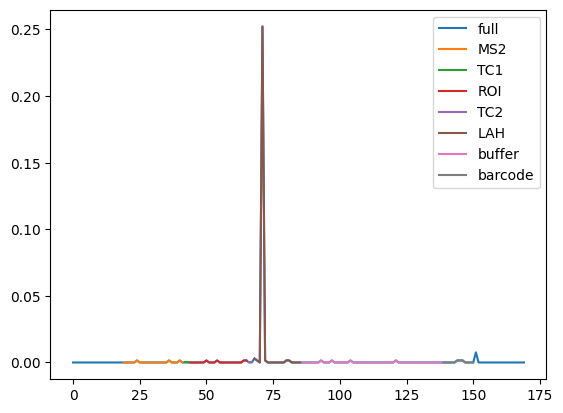

In [74]:
for sample in study.df['sample'].unique():
    for construct in study.get_df(sample=sample)['construct'].unique():
        read_coverage_per_position(study, sample, construct)
        savefig2(ipynbname.path(), '[D] Read coverage per position')
        if not config.generate_plots:
            break  